In [4]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.optimizers import SGD

In [5]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = "../data/ripeness_classification/apple/train"  # os.path.abspath("media")

datagen_kwargs = dict(rescale=1.0 / 255, validation_split=0.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, subset="validation", target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, subset="training", target_size=IMAGE_SHAPE
)

Found 18 images belonging to 2 classes.
Found 78 images belonging to 2 classes.


In [7]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = MobileNetV2(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 3 classes
predictions = Dense(2, activation='softmax')(x)  # Update the number of classes here

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])


steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(train_generator, epochs=5, verbose=1,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=valid_generator,
                    validation_steps=val_steps_per_epoch).history

Epoch 1/5
3/3 [==============================] - 9s 2s/step - loss: 3.1930 - accuracy: 0.6026 - val_loss: 1.2390 - val_accuracy: 0.5000
Epoch 2/5
3/3 [==============================] - 2s 557ms/step - loss: 1.4784 - accuracy: 0.5769 - val_loss: 0.4297 - val_accuracy: 0.8333
Epoch 3/5
3/3 [==============================] - 2s 726ms/step - loss: 0.2052 - accuracy: 0.9615 - val_loss: 0.3610 - val_accuracy: 0.8333
Epoch 4/5
3/3 [==============================] - 2s 727ms/step - loss: 0.1069 - accuracy: 0.9615 - val_loss: 0.4119 - val_accuracy: 0.7778
Epoch 5/5
3/3 [==============================] - 2s 741ms/step - loss: 0.0681 - accuracy: 0.9872 - val_loss: 0.4071 - val_accuracy: 0.7778


In [8]:
for layer in model.layers[:125]:
    layer.trainable = False
for layer in model.layers[125:]:
    layer.trainable = True


model.compile(
    optimizer=SGD(lr=0.0001, momentum=0.9),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [9]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(train_generator, epochs=5, verbose=1,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=valid_generator,
                    validation_steps=val_steps_per_epoch).history

Epoch 1/5
3/3 [==============================] - 9s 2s/step - loss: 0.2600 - accuracy: 0.8333 - val_loss: 0.5320 - val_accuracy: 0.8889
Epoch 2/5
3/3 [==============================] - 2s 740ms/step - loss: 0.1192 - accuracy: 0.9487 - val_loss: 0.8419 - val_accuracy: 0.7778
Epoch 3/5
3/3 [==============================] - 2s 652ms/step - loss: 0.0519 - accuracy: 0.9872 - val_loss: 0.9222 - val_accuracy: 0.8333
Epoch 4/5
3/3 [==============================] - 2s 649ms/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 0.9816 - val_accuracy: 0.8333
Epoch 5/5
3/3 [==============================] - 2s 654ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 1.0454 - val_accuracy: 0.8333


In [10]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

In [11]:
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Ripe' 'Unripe']


In [12]:
model.save_weights('../data/ripeness_classification/apple/weights/model_weights.h5')

In [13]:
tf_model_predictions = model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

1/1 [==============================] - 2s 2s/step
Prediction results shape: (18, 2)


In [14]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)

['Unripe' 'Ripe' 'Ripe' 'Unripe' 'Unripe' 'Ripe' 'Unripe' 'Ripe' 'Unripe'
 'Unripe' 'Unripe' 'Unripe' 'Unripe' 'Unripe' 'Ripe' 'Unripe' 'Ripe'
 'Unripe']


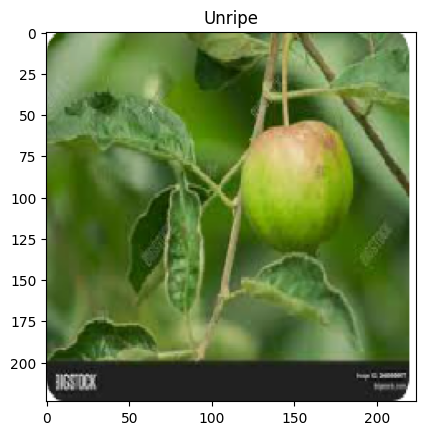

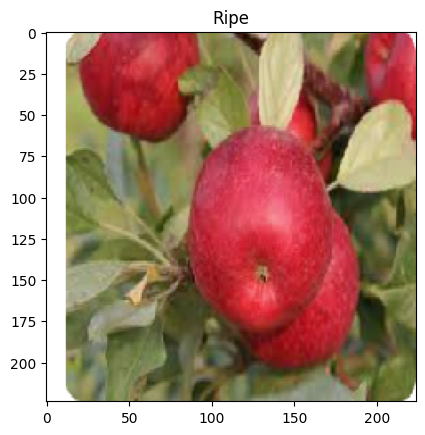

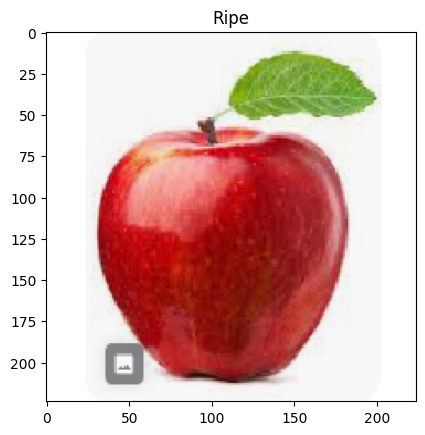

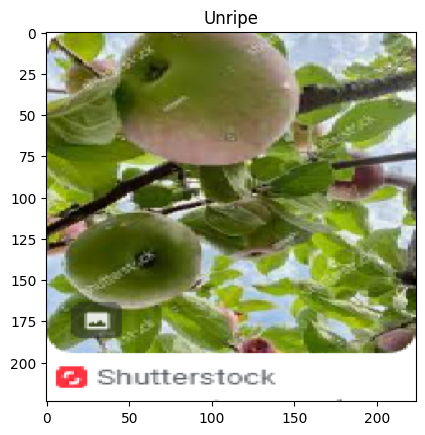

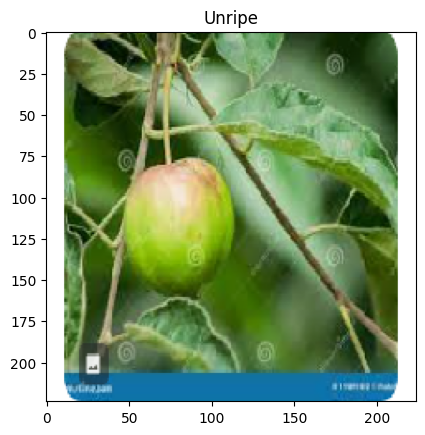

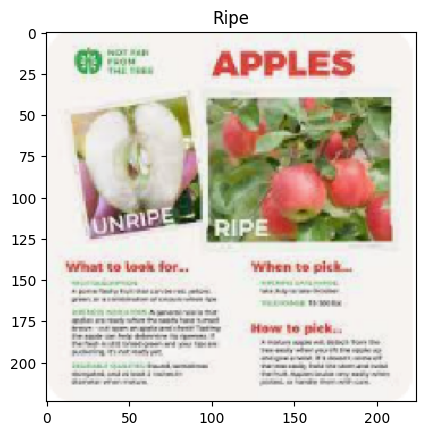

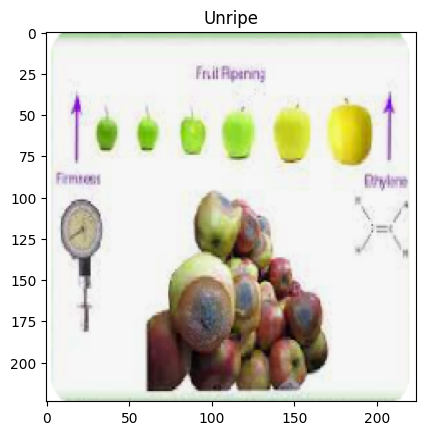

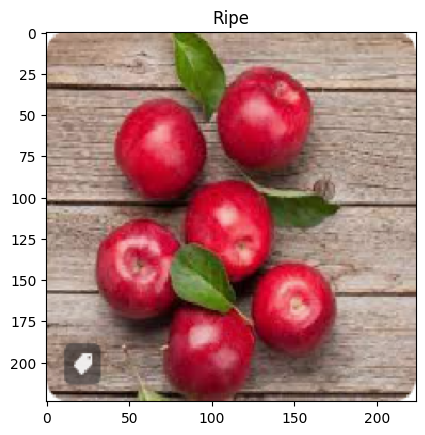

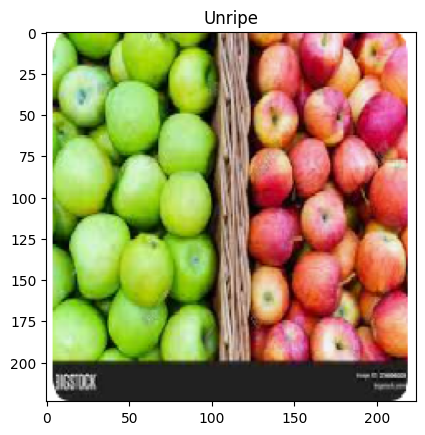

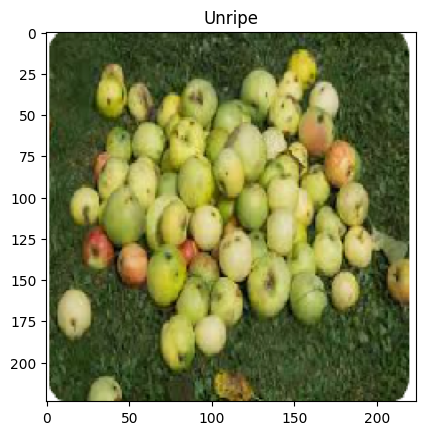

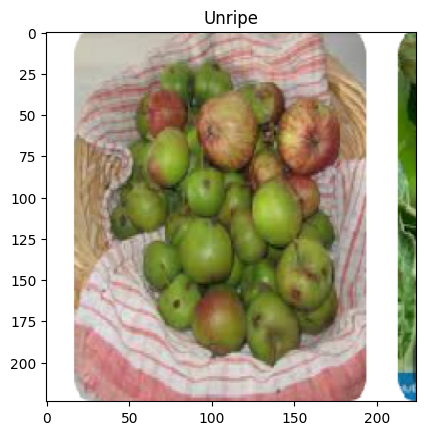

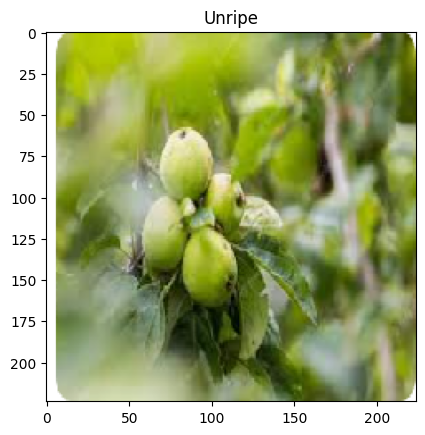

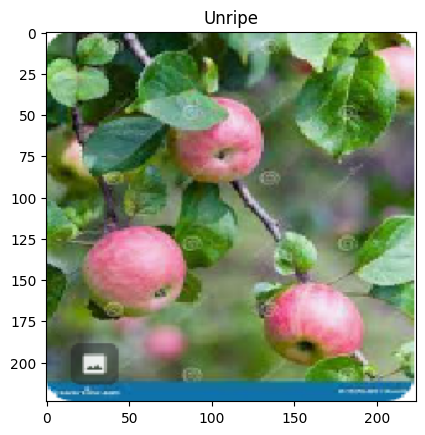

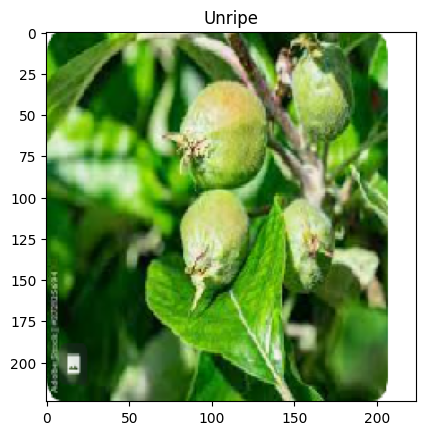

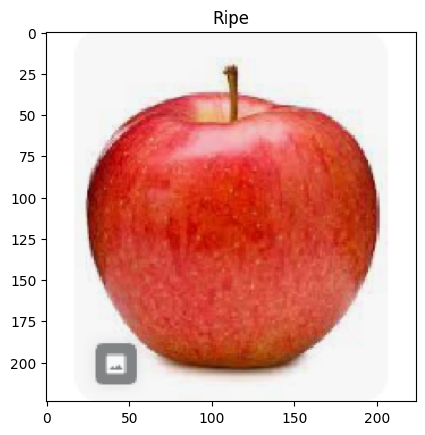

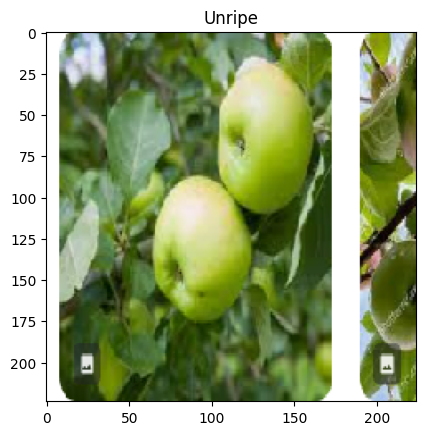

In [15]:
import matplotlib.pyplot as plt

for n in range((len(predicted_labels)-2)):
  plt.imshow(val_image_batch[n])
  plt.title(predicted_labels[n].title())
  plt.show()